In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sales_predictor import SalesPredictor
from complex_market import MarketEnv
from trainer import train

plt.rcParams['figure.figsize'] = [14, 8]

In [10]:
class SalesPredictor:
    def __init__(self, period, residuals_model):
        self.period = period
        self.residuals_model = residuals_model
    
    def fit(self, prices, sales):
        decomposition = seasonal_decompose(sales, model='additive', period=self.period)
        self.seasonal, trend, res = decomposition.seasonal, decomposition.trend, decomposition.resid
        self.first_week = weeks_from_date(self.seasonal.index)[0]
        
        trend = trend[~trend.isna()]
        # self._fit_trend(np.arange(trend.shape[0]), trend)
        
        res = res[~res.isna()]
        prices = prices.loc[res.index]
        
        self.residuals_model.fit(
            pd.DataFrame(
                data={
                    "prices": prices.reshape(-1),
                    "week": weeks_from_date(prices.index).reshape(-1)
            }),
            (res + trend).to_numpy().reshape(-1, 1)
        )

    # def _fit_trend(self, x, y):
    #     slope, intercept = np.polyfit(x, y, deg=1)
    #     self.trend_slope = slope
    #     self.trend_intercept = intercept
    
    def _predict_array(self, week, prices, verbose: bool = False):
        seasonal_pred = self.seasonal[(week - self.first_week) % 53]
        # pred_trend = self.trend_slope * week + self.trend_intercept
        
        pred_res = self.residuals_model.predict(
            pd.DataFrame(data={
                    "prices": prices.reshape(-1), 
                    "week": week.reshape(-1), 
            }))
        
        if pred_res.ndim > 1:
            pred_res = pred_res.squeeze(1)
            
        # if verbose:
        #     fig, ax = plt.subplots(3, 1, figsize=(25, 6))
        #     ax[0].plot(prices.index, seasonal_pred)
        #     ax[1].plot(prices.index, pred_trend)
        #     ax[2].plot(prices.index, pred_res)
        #     plt.show()
        
        # return seasonal_pred + pred_trend + pred_res
        return seasonal_pred + pred_res
    
    def predict(self, week, prices, verbose: bool = False):
        if not isinstance(week, np.ndarray) or not isinstance(prices, np.ndarray):
            sales_pred = self._predict_array(np.array([week]), np.array([prices]), verbose)
            return sales_pred[0]
        return self._predict_array(week, prices, verbose)


### Build Environment


Load forecasting model.

In [11]:
model_path = os.path.join("data", "sales_model.pkl")
sales_predictor = pickle.load(open(model_path, "rb"))

In [12]:
prime_cost = 100
min_price, max_price = prime_cost, prime_cost * 6

In [13]:
env = MarketEnv(sales_predictor, prime_cost)

### Train Agent

Tune hyperparameters in order to maximize agent's cummulative reward.

In [76]:
class MarketAgent:
    def __init__(self, min_price, max_price, bins_number, learning_rate=0.1, discount_factor=0.96,
                 exploration_rate=0.98, exploration_decay_rate=0.99, seasonality_period: int = 52):
        
        self.learning_rate = learning_rate
        self.min_price = min_price
        self.max_price = max_price
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.action_bins_number = bins_number
        
        self.state = None
        self.action = None
        
        self.seasonality_period = seasonality_period
        self.bins = np.linspace(self.min_price, self.max_price, self.action_bins_number)
        # store previous actions as well
        self.q = np.zeros((self.action_bins_number * self.seasonality_period, bins_number))
        
    def state_from_observation(self, obervation):
        week, prev_price = obervation
        if prev_price == None:
            prev_price = (self.max_price + self.min_price) // 2
            
        prev_price = np.digitize(prev_price, self.bins)
        state = (week - 1) % self.seasonality_period * self.action_bins_number + prev_price
        
        return state
        
    def begin_episode(self, observation):
        self.state = self.state_from_observation(observation)
        self.exploration_rate *= self.exploration_decay_rate
        enable_exploration = (1 - self.exploration_rate) <= np.random.uniform(0, 1)
        if enable_exploration:
            self.action = np.random.randint(0, self.action_bins_number)
        else:
            self.action = np.argmax(self.q[self.state])
            
        return self.bins[self.action]
    
    def act(self, observation, reward, done):
        next_state = self.state_from_observation(observation)
    
        self.q[self.state, self.action] = (1 - self.learning_rate) * self.q[self.state, self.action] + \
                                          self.learning_rate * (reward + self.discount_factor * np.max(self.q[next_state]))

        enable_exploration = (1 - self.exploration_rate) <= np.random.uniform(0, 1)
        if enable_exploration:
            next_action = np.random.randint(0, self.action_bins_number)
        else:
            next_action = np.argmax(self.q[next_state])
            
        self.state = next_state
        self.action = next_action

        return self.bins[next_action]
    
    def get_optimal_action(self, observation):
        self.state = self.state_from_observation(observation)
        return self.bins[np.argmax(self.q[self.state])]

In [77]:
learning_rate=0.1
discount_factor=0.96
exploration_rate=0.98
exploration_decay_rate=0.99
bins_number=100
episodes=1000

In [78]:
rl_agent = MarketAgent(min_price, max_price, bins_number, learning_rate, discount_factor, exploration_rate,
                       exploration_decay_rate)

In [79]:
rl_rewards = train(env, rl_agent, episodes, print_every=50)

Episode 0; Mean reward = 62512.915974080526
Episode 50; Mean reward = 79190.92437157338
Episode 100; Mean reward = 86634.82235064493
Episode 150; Mean reward = 84098.17190067621
Episode 200; Mean reward = 90523.34018901271
Episode 250; Mean reward = 90128.97500593816
Episode 300; Mean reward = 91189.11142310778
Episode 350; Mean reward = 91285.53990614248
Episode 400; Mean reward = 91019.43431571608
Episode 450; Mean reward = 90258.70539362538
Episode 500; Mean reward = 90258.70539362538
Episode 550; Mean reward = 90258.70539362538
Episode 600; Mean reward = 90258.70539362538
Episode 650; Mean reward = 90258.70539362538
Episode 700; Mean reward = 90258.70539362538
Episode 750; Mean reward = 90258.70539362538
Episode 800; Mean reward = 90258.70539362538
Episode 850; Mean reward = 90258.70539362538
Episode 900; Mean reward = 90258.70539362538
Episode 950; Mean reward = 90258.70539362538


Text(0, 0.5, 'Cummulative Reward')

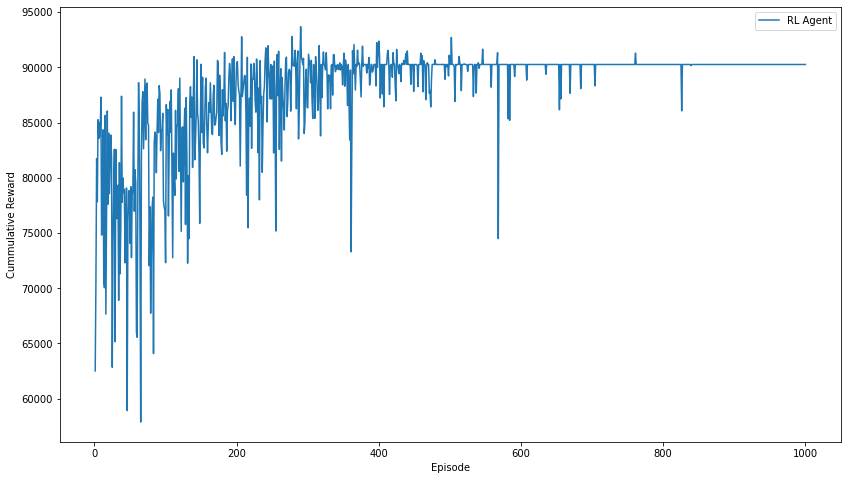

In [81]:
plt.plot(np.arange(1, episodes + 1), rl_rewards, label="RL Agent")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Cummulative Reward")

### RL vs Greedy strategy

Implement greedy agent, which exploits optimal 1-step reward maximization startegy. It can be find analytically by finding an extremum of a reward (profit) function.

In [82]:
class GreedyAgent:
    def __init__(self, sales_predictor, prime_cost):
        self.sales_predictor = sales_predictor
        self.prime_cost = prime_cost
    
    def get_optimal_action(self, observation):
        t = observation[0] - 1
        s = self.sales_predictor.seasonal
        prices_c, week_c = self.sales_predictor.residuals_model.coef_
        intercept = self.sales_predictor.residuals_model.intercept_
    
        p_opt = - (intercept - prices_c * self.prime_cost - week_c * t + s[t]) / (2 * prices_c)
    
        return max(min_price, min(p_opt, max_price))


In [83]:
def validate(env, agent):
    reward_sum = 0

    observation = env.reset()
    action = agent.get_optimal_action(observation)
    done = False

    while True:
        observation, reward, done = env.step(action)
        reward_sum += reward
        
        if done:
            break
            
        action = agent.get_optimal_action(observation)

    return reward_sum

In [84]:
greedy_agent = GreedyAgent(sales_predictor, prime_cost)

RL agent should outperform greedy agent. Can you explain why?

In [85]:
print(f"Greedy agent cummulative reward = {validate(env, greedy_agent)}")
print(f"RL agent cummulative reward = {validate(env, rl_agent)}")

Greedy agent cummulative reward = [88720.14422258]
RL agent cummulative reward = 90258.70539362538
